In [1]:
# Block 1
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return residual + out

class Generator(nn.Module):
    def __init__(self, num_res_blocks=5, num_channels=64):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.middle = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_channels)
        )
        self.upsample_blocks = nn.Sequential(
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.final = nn.Conv2d(num_channels, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.res_blocks(x)
        x = self.middle(x) + residual
        x = self.upsample_blocks(x)
        x = self.final(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        features = [64, 128, 256, 512]
        layers = []
        for i in range(1, len(features)):
            layers.append(nn.Conv2d(features[i-1], features[i], kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(features[i], features[i], kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.middle = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.middle(x)
        x = self.final(x)
        return x


In [2]:
# Block 2
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
print(device)

cpu


In [4]:
#4
!nvidia-smi

Sun May  5 13:41:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.74       Driver Version: 512.74       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   34C    P0    13W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Block 3
from datasets import load_dataset

div2k_dataset = load_dataset("eugenesiow/Div2k")
print(div2k_dataset)

train_data = div2k_dataset["train"]
validation_data = div2k_dataset["validation"]

for sample in train_data[:5]:
    print(sample)


DatasetDict({
    train: Dataset({
        features: ['lr', 'hr'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['lr', 'hr'],
        num_rows: 100
    })
})
lr
hr


In [6]:
# Block 4
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset

class Div2kDataset(Dataset):
    def __init__(self, div2k_data, transform=None, target_size=(256, 256)):
        self.div2k_data = div2k_data
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.div2k_data)

    def __getitem__(self, idx):
        lr_image_path = self.div2k_data[idx]['lr']
        hr_image_path = self.div2k_data[idx]['hr']
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = lr_image.resize(self.target_size, Image.BICUBIC)
        hr_image = hr_image.resize(self.target_size, Image.BICUBIC)
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        return lr_image, hr_image

div2k_dataset = load_dataset("eugenesiow/Div2k", split='train[:200]')
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = Div2kDataset(div2k_dataset, transform=transform)
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [14]:
len(train_loader)

200

In [7]:
# Block 5
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset

class Div2kDataset(Dataset):
    def __init__(self, div2k_data, transform=None):
        self.div2k_data = div2k_data
        self.transform = transform  # Corrected from 'this.transform = transform'

    def __len__(self):
        return len(self.div2k_data)

    def __getitem__(self, idx):
        lr_image_path = self.div2k_data[idx]['lr']
        hr_image_path = self.div2k_data[idx]['hr']
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        low_resolution_transform = transforms.Compose([
            transforms.Resize((96, 96), Image.BICUBIC),
            transforms.ToTensor(),
        ])
        high_resolution_transform = transforms.Compose([
            transforms.Resize((384, 384), Image.BICUBIC),
            transforms.ToTensor(),
        ])
        lr_image = low_resolution_transform(lr_image)
        hr_image = high_resolution_transform(hr_image)
        return lr_image, hr_image

div2k_dataset = load_dataset("eugenesiow/Div2k", split='train[:200]')
train_dataset = Div2kDataset(div2k_dataset)
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
lr_example, hr_example = next(iter(train_loader))
lr_dimensions = tuple(lr_example.shape[-2:])
hr_dimensions = tuple(hr_example.shape[-2:])
print("LR image dimensions:", lr_dimensions)
print("HR image dimensions:", hr_dimensions)


LR image dimensions: (96, 96)
HR image dimensions: (384, 384)


In [8]:
# Block 6
import torchvision.models as models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=34, use_bn=False):
        super(VGGFeatureExtractor, self).__init__()
        vgg = models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:feature_layer+1])
        self.use_bn = use_bn

    def forward(self, x):
        if self.use_bn:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
            x = (x - mean) / std
        return self.feature_extractor(x)

feature_extractor = VGGFeatureExtractor(feature_layer=34, use_bn=True).to(device)


C:\Users\juver\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juver\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
'''
# Block 7
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

checkpoint_path = r'C:\Users\91962\Downloads\projcv\model_checkpoint2.pth'

generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)

criterion_bce = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()
criterion_feature = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 100
adversarial_loss_weight = 1e-3
pixel_loss_weight = 1
log_interval = 100
save_interval = 2

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for batch_idx, (blurred_images, sharp_images) in enumerate(train_loader):
        blurred_images = blurred_images.to(device)
        sharp_images = sharp_images.to(device)
        optimizer_D.zero_grad()
        fake_sharp_images = generator(blurred_images)
        real_outputs = discriminator(sharp_images)
        fake_outputs = discriminator(fake_sharp_images.detach())
        d_loss = (criterion_bce(real_outputs, torch.ones_like(real_outputs)) + criterion_bce(fake_outputs, torch.zeros_like(fake_outputs)))/2
        d_loss.backward()
        optimizer_D.step()
        optimizer_G.zero_grad()
        fake_sharp_images1 = discriminator(fake_sharp_images)
        adversarial_loss = criterion_bce(fake_sharp_images1, torch.ones_like(fake_sharp_images1))
        sharp_images_resized = F.interpolate(sharp_images, size=fake_sharp_images1.shape[2:], mode='nearest')
        pixel_loss = criterion_pixel(fake_sharp_images1, sharp_images_resized)
        with torch.no_grad():
            real_features = feature_extractor(sharp_images)
            fake_features = feature_extractor(fake_sharp_images1)
            real_features_resized = F.interpolate(real_features, size=fake_features.shape[2:], mode='nearest')
        feature_loss = criterion_feature(fake_features, real_features_resized)
        total_loss = (adversarial_loss_weight * adversarial_loss + pixel_loss_weight * pixel_loss)/2
        total_loss.backward()
        optimizer_G.step()
        if batch_idx % log_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                  f"Generator Loss: {total_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'total_loss': total_loss
        }, checkpoint_path)
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 129-130: truncated \UXXXXXXXX escape (1732607231.py, line 66)

In [10]:
# Block 7
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

checkpoint_path = r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth'

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_bce = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()
criterion_feature = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 100
adversarial_loss_weight = 1e-3
pixel_loss_weight = 1
feature_loss_weight = 0.01  # Adjust the weight for feature loss
log_interval = 100
save_interval = 2

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for batch_idx, (low_res_images, high_res_images) in enumerate(train_loader):
        low_res_images, high_res_images = low_res_images.to(device), high_res_images.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        fake_high_res_images = generator(low_res_images)
        real_output = discriminator(high_res_images)
        fake_output = discriminator(fake_high_res_images.detach())
        loss_real = criterion_bce(real_output, torch.ones_like(real_output))
        loss_fake = criterion_bce(fake_output, torch.zeros_like(fake_output))
        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_high_res_images)
        g_loss_fake = criterion_bce(fake_output, torch.ones_like(fake_output))
        pixel_loss = criterion_pixel(fake_high_res_images, high_res_images)

        # Feature Loss (ensure features are extracted from the correct image sizes)
        real_features = feature_extractor(high_res_images)
        fake_features = feature_extractor(fake_high_res_images)
        feature_loss = criterion_feature(fake_features, real_features)

        g_loss = g_loss_fake + pixel_loss_weight * pixel_loss + feature_loss_weight * feature_loss
        g_loss.backward()
        optimizer_G.step()

        if batch_idx % log_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, checkpoint_path)


Epoch [0/100], Batch [0/200], D Loss: 0.7234, G Loss: 1.0041
Epoch [0/100], Batch [100/200], D Loss: 0.5069, G Loss: 0.9788
Epoch [1/100], Batch [0/200], D Loss: 0.5036, G Loss: 0.9661
Epoch [1/100], Batch [100/200], D Loss: 0.8133, G Loss: 0.5840
Epoch [2/100], Batch [0/200], D Loss: 0.8133, G Loss: 0.5200
Epoch [2/100], Batch [100/200], D Loss: 0.6931, G Loss: 0.9902
Epoch [3/100], Batch [0/200], D Loss: 0.6931, G Loss: 0.9330
Epoch [3/100], Batch [100/200], D Loss: 0.6932, G Loss: 0.9684
Epoch [4/100], Batch [0/200], D Loss: 0.6931, G Loss: 0.9720
Epoch [4/100], Batch [100/200], D Loss: 0.6932, G Loss: 0.9885
Epoch [5/100], Batch [0/200], D Loss: 0.6931, G Loss: 0.9015
Epoch [5/100], Batch [100/200], D Loss: 0.6931, G Loss: 1.0909
Epoch [6/100], Batch [0/200], D Loss: 0.6931, G Loss: 0.8929
Epoch [6/100], Batch [100/200], D Loss: 0.6931, G Loss: 1.0372
Epoch [7/100], Batch [0/200], D Loss: 0.6931, G Loss: 0.8603
Epoch [7/100], Batch [100/200], D Loss: 0.6931, G Loss: 0.8622
Epoch [8

KeyboardInterrupt: 

In [12]:
'''
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize
from datasets import load_dataset

class Div2kValidationDataset(Dataset):
    def __init__(self, div2k_data, transform=None, target_size=(384, 384)):  # Use double underscores for method names
        self.div2k_data = div2k_data
        self.transform = transform
        self.target_size = target_size

    def __len__(self):  # Use double underscores for method names
        return len(self.div2k_data)

    def __getitem__(self, idx):  # Use double underscores for method names
        lr_image_path = self.div2k_data[idx]['lr']
        hr_image_path = self.div2k_data[idx]['hr']
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        hr_image = resize(np.array(hr_image), self.target_size, preserve_range=True, anti_aliasing=True)
        if self.transform:
            lr_image = self.transform(lr_image)
        hr_image = transforms.ToTensor()(hr_image)
        return lr_image, hr_image

# Load the dataset
div2k_validation_dataset = load_dataset("eugenesiow/Div2k", split='validation[:100]')
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Low-resolution images resized for model input
    transforms.ToTensor()
])
validation_dataset = Div2kValidationDataset(div2k_validation_dataset, transform=transform, target_size=(384, 384))
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

# Assume Generator is defined elsewhere and correctly imported
# Load the model from a checkpoint
device = torch.device('cpu')  # Adjust as necessary for your setup
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth', map_location=device)
generator = Generator().to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Evaluate
psnrs = []
ssims = []
for lr_image, hr_image_true in validation_loader:
    lr_image = lr_image.to(device)
    hr_image_true = hr_image_true.to(device)  # HR image already resized in _getitem_
    with torch.no_grad():
        hr_image_pred = generator(lr_image)
        hr_image_pred = hr_image_pred.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy() * 255
    hr_image_true = hr_image_true.permute(0, 2, 3, 1).cpu().numpy() * 255  # Correct dimension ordering and scaling

    # Calculate metrics for each image in the batch
    for true, pred in zip(hr_image_true, hr_image_pred):
        psnr = peak_signal_noise_ratio(true.astype(np.uint8), pred.astype(np.uint8), data_range=255)
        #ssim = structural_similarity(true.astype(np.uint8), pred.astype(np.uint8), multichannel=True, data_range=255, win_size=11)
        psnrs.append(psnr)
        #ssims.append(ssim)

# Calculate and print average metrics
print(f"Average PSNR: {np.mean(psnrs):.2f}")
print(f"Average SSIM: {np.mean(ssims):.4f}")

'''

Average PSNR: 8.07
Average SSIM: nan


C:\Users\juver\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\juver\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
@#print(np.max(psnrs))

10.804669512835268


In [2]:
'''
# Block 8
from PIL import Image
from torchvision import transforms

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image
'''

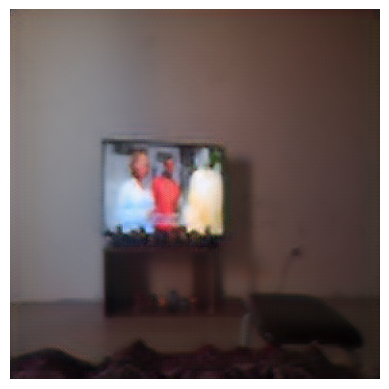

In [3]:
'''
import torch
from torchvision import transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from PIL import Image

# Load the checkpoint and setup the generator
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth', map_location='cpu')
generator = Generator()
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Define the path to your low-resolution image
image_path = 'C:/Users/juver/Downloads/archive (1)/motion_blurred/9_HUAWEI-P20_M.jpg'   # Make sure the path is correct

# Transform pipeline for the image
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to the input size expected by your model
    transforms.ToTensor()         # Convert image to a PyTorch tensor
])

# Load the image, apply the transform, and ensure correct dimensionality
lr_image = Image.open(image_path).convert('RGB')
lr_image = transform(lr_image)
lr_image = lr_image.unsqueeze(0)  # Add a batch dimension if not already present

# Move the image tensor to the correct device
device = torch.device('cpu')  # Or 'cuda' if you are using GPU
lr_image = lr_image.to(device)

# Generate high-resolution image
with torch.no_grad():
    hr_image = generator(lr_image)  # No need to unsqueeze if already done

# Normalize and convert to PIL for display and saving
hr_image = hr_image.squeeze(0)  # Remove batch dimension
hr_image = torch.clamp(hr_image, 0, 1)  # Clamp values to valid image range
to_pil = ToPILImage()
hr_image_pil = to_pil(hr_image.cpu())  # Convert to CPU if necessary

# Display the image
plt.imshow(hr_image_pil)
plt.axis('off')  # Hide axes
plt.show()

# Optionally, save the image if needed
# hr_image_pil.save('C:/path/to/save/high-resolution/output_image.png')
'''

In [ ]:
'''
patch_size = 24  # Size of the patches
num_patches = 4  # Number of patches per dimension (assuming square)

# Helper function to extract patches
def extract_patches(images, patch_size, num_patches):
    batch_size, channels, height, width = images.shape
    patches = []
    step = patch_size
    for i in range(0, height, step)[:num_patches]:
        for j in range(0, width, step)[:num_patches]:
            patches.append(images[:, :, i:i+patch_size, j:j+patch_size])
    return torch.cat(patches, 0)
'''

In [ ]:
'''
patch_size = 24  # Size of the patches
num_patches = 4  # Number of patches per dimension (assuming square)

# Helper function to extract patches
def extract_patches(images, patch_size, num_patches):
    batch_size, channels, height, width = images.shape
    patches = []
    step = patch_size
    for i in range(0, height, step)[:num_patches]:
        for j in range(0, width, step)[:num_patches]:
            patches.append(images[:, :, i:i+patch_size, j:j+patch_size])
    return torch.cat(patches, 0)

for epoch in range(num_epochs):
    for batch_idx, (low_res_images, high_res_images) in enumerate(train_loader):
        low_res_images, high_res_images = low_res_images.to(device), high_res_images.to(device)
        patches_high_res = extract_patches(high_res_images, patch_size, num_patches)
        fake_high_res_images = generator(low_res_images)
        patches_fake_high_res = extract_patches(fake_high_res_images, patch_size, num_patches)

        # Train Original Discriminator
        # Existing code ...

        # Train Patch Discriminator
        optimizer_PD.zero_grad()
        real_patch_output = patch_discriminator(patches_high_res)
        fake_patch_output = patch_discriminator(patches_fake_high_res.detach())
        loss_real_patch = criterion_bce(real_patch_output, torch.ones_like(real_patch_output))
        loss_fake_patch = criterion_bce(fake_patch_output, torch.zeros_like(fake_patch_output))
        pd_loss = (loss_real_patch + loss_fake_patch) / 2
        pd_loss.backward()
        optimizer_PD.step()

        # Train Generator
        # Modify generator training to consider patch discriminator loss
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_high_res_images)
        fake_patch_output = patch_discriminator(patches_fake_high_res)
        g_loss_fake = criterion_bce(fake_output, torch.ones_like(fake_output))
        g_loss_fake_patch = criterion_bce(fake_patch_output, torch.ones_like(fake_patch_output))
        # Existing feature and pixel loss code ...

        g_loss = g_loss_fake + g_loss_fake_patch + pixel_loss_weight * pixel_loss + feature_loss_weight * feature_loss
        g_loss.backward()
        optimizer_G.step()

        # Existing logging and checkpointing code...
'''

In [ ]:
'''
# Block 7
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

checkpoint_path = r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth'

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_bce = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()
criterion_feature = nn.MSELoss()

patch_discriminator = PatchDiscriminator().to(device)
optimizer_PD = optim.Adam(patch_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 100
adversarial_loss_weight = 1e-3
pixel_loss_weight = 1
feature_loss_weight = 0.01  # Adjust the weight for feature loss
log_interval = 100
save_interval = 2

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for batch_idx, (low_res_images, high_res_images) in enumerate(train_loader):
        low_res_images, high_res_images = low_res_images.to(device), high_res_images.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        fake_high_res_images = generator(low_res_images)
        real_output = discriminator(high_res_images)
        fake_output = discriminator(fake_high_res_images.detach())
        loss_real = criterion_bce(real_output, torch.ones_like(real_output))
        loss_fake = criterion_bce(fake_output, torch.zeros_like(fake_output))
        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Patch Discriminator
        optimizer_PD.zero_grad()
        real_patch_output = patch_discriminator(patches_high_res)
        fake_patch_output = patch_discriminator(patches_fake_high_res.detach())
        loss_real_patch = criterion_bce(real_patch_output, torch.ones_like(real_patch_output))
        loss_fake_patch = criterion_bce(fake_patch_output, torch.zeros_like(fake_patch_output))
        pd_loss = (loss_real_patch + loss_fake_patch) / 2
        pd_loss.backward()
        optimizer_PD.step()
        
        # Train Generator
        # Modify generator training to consider patch discriminator loss
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_high_res_images)
        fake_patch_output = patch_discriminator(patches_fake_high_res)
        g_loss_fake = criterion_bce(fake_output, torch.ones_like(fake_output))
        g_loss_fake_patch = criterion_bce(fake_patch_output, torch.ones_like(fake_patch_output))
        # Existing feature and pixel loss code ...

        g_loss = g_loss_fake + g_loss_fake_patch + pixel_loss_weight * pixel_loss + feature_loss_weight * feature_loss
        g_loss.backward()
        optimizer_G.step()

        if batch_idx % log_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, checkpoint_path)

'''